# 3D Pose Estimation and objectron for object selection

## Brief
- Due
    - Code 11/24/2020 11:59PM 
    - Report 11/24/2020 11:59PM (in the zip)
- Hand-in: through Gradescope
- Required files: 
    - `<your_gt_username>.zip` against [Project 5 - Code](https://www.gradescope.com/courses/155064/assignments/838181)
    - PDF report against [Project 5 - Report](https://www.gradescope.com/courses/155064/assignments/838831)
        

## Outline
The goal of this project is for you to experience working with state of the art libraries and real-time processing of video. We will be working with [MediaPipe](https://google.github.io/mediapipe/) which offers customizable Machine Learning solutions for live and streaming media. In this opportunity, we will use: [pose estimation](https://google.github.io/mediapipe/solutions/pose) which estimates the pose of a person in real time; and [objectron](https://google.github.io/mediapipe/solutions/objectron.html) which is a 3D object detector from 2D images.  With these two we will aim to identify an object that is being touched by a person. 


## Environment Setup!!

The environment setup is different from previous project, and so it's important that you carefully read and follow the instructions carefully:
- Install <a href="https://conda.io/miniconda.html">Miniconda</a>. It doesn't matter whether you use 2.7 or 3.6 because we will create our own environment anyways.
- Create a conda environment, using the appropriate command. On Linux, you can just use a terminal window to run the command. Modify the command based on your OS ('linux', 'mac'): `conda env create -f proj5_env_<OS>.yml`
- This should create an environment named `proj5`. Activate it using the following Windows command: `activate proj5` or the following MacOS / Linux command: `source activate proj5`.
- Install tensorflow via `pip install tensorflow`
- Install Mediapipe via `pip install mediapipe`
- Special notice to Windows user, it seems mediapipe does not have good support for Windows system, and so you are strongly suggested to use other operating systems or try to set up a CoLab environment. There may be some path issues that you have to modify if you want to run it on Colab.
- Special notice to Mac user, it seems many students also have problem with configuring their running environment even though mediapipe claims it can be installed via pip. So if you meet installation problems, please also consider using Colab, or try to follow installation instructions posed by Mediapipe's official website.
- Run `pip install -e .` (Mac user may have problems with this line of code too, in that case, please switch to CoLab too)
- Run the notebook using: `jupyter notebook proj5_code/proj5.ipynb`
- After finishing all your functions, please check their correctness via `pytest` in the folder `proj5_unit_tests`
- Generate the submission once you're finished using `python zip_submission.py`

## Part 1: 3D bounding box detection on 2D images

In [1]:
%load_ext autoreload
%autoreload 2

import os
from PIL import Image
import matplotlib.pyplot as plt
# import mediapipe as mp
import numpy as np
import cv2

from proj5_code.utils import *
from proj5_code.my_objectron import *
from proj5_code.pose_estimate import *
from proj5_code.intersection import *
from proj5_code.pnp import *

from proj5_unit_tests.test_base import *
from proj5_unit_tests.test_my_objectron import *
from proj5_unit_tests.test_pose_estimate import *
from proj5_unit_tests.test_intersection import *
from proj5_unit_tests.test_pnp import *
from proj5_unit_tests.test_utils import *

We're going to use mediapipe's [objectron](https://google.github.io/mediapipe/solutions/objectron) library based on this [paper](https://arxiv.org/pdf/2003.03522.pdf) to detect 3D bounding boxes of chairs in images. An example is shown in the figure below.

<img src="https://google.github.io/mediapipe/images/mobile/objectron_chair_android_gpu.gif" width="150"/>
<center>3D Objectron example.</center>

**Basically**, there are an encoder and a decoder for the detection part. Given an image, the encoder takes it as input, analyzes it, and gives some useful information in a certain form. Then the decoder takes these intermediate information as input, translates them into things we want (i.e., 8 vertices' 2D coordinates). 
The encoder is trained as a neural network, whose weight file is provided and can be read by Tensorflow (which is the `inference()` function in `my_objectron.py`). The decoder part is implemented as the `decode()` function in `my_objectron.py`. **You should read the paper and figure out what is the intermediate information to finish the coding work, otherwise you will not understand how to write the code for this section or answer the report reflection questions.**

Most of the code is already implemented for you based on one github [repository](https://github.com/yas-sim/objectron-3d-object-detection-openvino).

### Detecting the 3D bounding boxes from the sample image

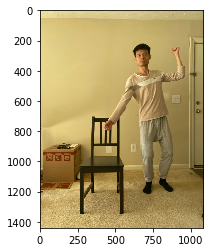

In [2]:
test_img='../data/10.jpg'
img = cv2.imread(test_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

**TODO**:  fill in the `detect_3d_box()` in `my_objectron.py`

[[1, 3, 640, 480]] [[1, 16, 40, 30], [1, 1, 40, 30]]
0.9636402130126953


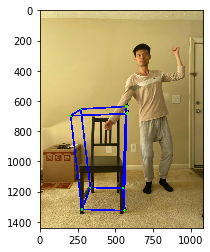

[(0.3071890190243721, 0.8147120207548142), (0.25577648878097536, 0.9146355867385865), (0.2490603715181351, 0.45441167354583745), (0.1863859832286835, 0.48483673036098485), (0.5049543023109436, 0.817148107290268), (0.5124380230903626, 0.920136097073555), (0.5240779161453247, 0.4428676247596741), (0.5281747370958328, 0.47536436021327977)]


In [3]:
bounding_boxes_chair_2d, annotated_img = detect_3d_box(test_img)
plt.imshow(annotated_img)
plt.show()
print(bounding_boxes_chair_2d)

In [4]:
print("Testing your objectron detection: ", verify(test_my_objectron))


[[1, 3, 640, 480]] [[1, 16, 40, 30], [1, 1, 40, 30]]
0.9799638986587524
Testing your objectron detection:  "Correct"


## Part 2 Estimation of world coordinates of the camera


### 2.1 Establish the world coordinate frame

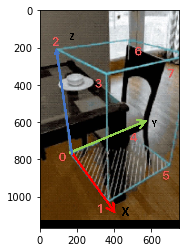

In [5]:
img_index = cv2.imread('../data/world_frame.png')
img_index = cv2.cvtColor(img_index, cv2.COLOR_BGR2RGB)
plt.imshow(img_index)
plt.show()

Similar to the previous project, we want to estimate the intrinsic camera matrix, but this time we will provide an initial estimation for a cube, giving 8 vertices in 3D coordinate. As shown in the previous image we have 8 vertices and we can define the world coordinate using this vertices. We will define the origin of the world at the vertice 0, the `x-axis` will be given by the line that connects vertices 0 and 1, the `y-axis` will be given by vertices 0 and 4, and `z-axis` by vertices 0 and 2. Then, we need to give an estimation of the dimensions of the chair to calculate the location of the coordinates in the world frame. For our example, the chair have dimensions 0.4 x 0.4 x 1.0 m. For this, you will have to write the function that take the estimation of the dimensions of the chair and outputs the location of the 8 vertices in the world coordinate.

**TODO**:  fill in the `get_world_vertices()` in `utils.py`

In [6]:
# You need to measure the size of chair at first, and set their values there. 
# For example, the example chair's size is 0.4m * 0.4m *1.0m
size_x = 0.4
size_y = 0.4
size_z = 1.0
vertices_world = get_world_vertices(size_x, size_y, size_z)
print(vertices_world)

initial_box_points_3d = vertices_world
print("Testing your get_world_vertices: ", verify(test_get_world_vertices))

[[0.  0.  0. ]
 [0.4 0.  0. ]
 [0.  0.  1. ]
 [0.4 0.  1. ]
 [0.  0.4 0. ]
 [0.4 0.4 0. ]
 [0.  0.4 1. ]
 [0.4 0.4 1. ]]
Testing your get_world_vertices:  "Correct"


### 2.2 Estimate intrinsic matrix of your camera

For the camera intrinsic matrix, we can atually use some tools in opencv to calibrate our camera. You need to take several pictures **(better > 10)** from **different angles** of a checkerboard (showing a checkerboard pic on your computer and take picture of this checkerboard) with your camera. You can refer to the pictures in the *../data/cali2/example* folder. Then you can upload your pictures in the ***../data/cali*** folder and use this to get more accurate intrinsic matrix of the camera. 


The checkerboard that we used for calibration can be found in the `data` folder: `Checkerboard-A4-35mm-7x4.pdf`. There are also two video demoes about how to do camera calibration: [Example1-Camera Calibration](https://www.youtube.com/watch?v=HNfPbw-1e_w), this is for explaining the checkerboard, but you don't need to measure the length of grid on the checkboard. [Example2-Camera Calibration](https://www.youtube.com/watch?v=v7jutAmWJVQ), you need to take pictures as 1:30-1:50 in the video, you can either move the checkboard like in the video or move you camera(When you decide to move the checkboard, your camera need to stay at the same position all the time and vice versa).

The `calibrate` function requires the number of grids to be provided. If you use the checkerboard provided in the `data` folder, you can simply use the default parameters for `calibrate` function. If you want to try your own checkerboard, please note that the part used for calibration is two subgrids smaller than the actual in both x and y direction. For example, the example picture, the checkerboard has 5 x 8 subgrids, then the part used for calibration should be 3 x 6, thus the vertice number should be 4 x 7 (corresponding to m and n in `calibrate` function).

If you are interested in what is the mechanism in calibrating a camera with checkerboard, you can refer to [WiKi- Camera Calibration](https://en.wikipedia.org/wiki/Chessboard_detection#:~:text=Chessboard%20camera%20calibration,-A%20classical%20problem&text=Chessboards%20are%20often%20used%20during,interest%20points%20in%20an%20image.) and [OpenCV Doc](https://docs.opencv.org/3.4/d4/d94/tutorial_camera_calibration.html)

Important tips:
- Look at the example calibration pictures at first
- Cover different views by taking pictures from different angles, and avoid very similar pictures
- Use the pictures of the same resolution for all the tasks; Usually, phone camera uses different zoom for taking pictures and record videos. 
- By default, phone cameras usually adjust focal length automatically. You need to find a way to fix that. 

In [7]:
from proj5_code.calibration import calibrate

path2 = '../data/cali2/example2/' # update the path to where you save the pictures
m = 5 # m is the vertice number in x direction
n = 7 # n is the vertice number in y direction

K = calibrate(path2)

# K = np.array([[ 480,   0, 240],
#               [   0, 640, 320],
#               [   0,   0,  1]])

# ../data/cali2/example2/*.jpg
# [[1.11573975e+03 0.00000000e+00 7.22275004e+02]
#  [0.00000000e+00 1.06794751e+03 5.31184727e+02]
#  [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

../data/cali2/example2/*.jpg
[[1.11573975e+03 0.00000000e+00 7.22275004e+02]
 [0.00000000e+00 1.06794751e+03 5.31184727e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### 2.3 Estimate camera pose

After you get the 8 vertices of the box in 2D coordinate and the camera intrinsic matrix, we can recover the projection matrix by method called perspective-n-point method. Perspective-n-Point is a typical problem in 3D geometry estimating the pose of a calibrated camera given n 3D points in world and their corresponding 2D projected points on image frame. There are several way to get the projection matrix given the 2D-3D correspondence.

* **Direct Linear Transform (DLT)**, we use this method in proj4 to solve the projection matrix. Remember in previous project, we mentioned P has 11 DoF, thus we need at least 6 correspondencse to get the P. But this method has limitation on accuracy because it uses SVD to solve the P as a 12x1 vector ignoring the inner connection of all 12 parameters.

* **Perspective-3-Point (P3P)**, is the minimal form of PnP problem. This method uses the law of cosines to give extra constraints of the 6 triangles (3 similar triagle pairs) formed by the 3 correspondence and camera center. This method has disadvantages of limitation on information given only by three correspondence. Besides, when there are noises in the three correspondence, it is not robust.

* **Perspective-n-Point (PnP)**, is a often used pose estimation method which is more robust. Use the projection model, we can define the reprojection error, which is the difference between the projected 3D points and their matched 2D points, here the intrinsic matrix K should be known. Then given an initial estimation of camera pose, you can solve the problem by using nonlinear optimization. Give some perturbation to the intial estimation and then calculate the jacobian and hessian matrix, then you can get a update on your intial estimation. Repeat the process untill the error converges, you will get a well optimized camera pose. You can also refer to the [Wiki-Perspective-n-Point](https://en.wikipedia.org/wiki/Perspective-n-Point) to know more.

**Note:** The rotation and translation returned by cv2.solvePnP is different with what we deal with in project4. In project4, we use the notations below:

- ${}^wR_c$: for rotation of the camera in the world coordinate frame
- ${}^wt_c$: for translation of the camera in the world coordinate frame, which is the **camera_center**
- ${}^cR_w$: ${}^cR_w = {{}^wR_c}^T$

**In proj4**, The projection matrix **P**

\begin{align}
\mathbf
{P}=  \mathbf{K} \: {}^w \mathbf{R}_c^\top [ \mathbf{I}\;|\; -{}^w \mathbf{t}_c ] =
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

And this transform from world coordinate to camera coordinate:

$$\begin{bmatrix}X_c\\Y_c\\Z_c\\1\end{bmatrix} = \begin{bmatrix}\mathbf{{}^wR_c^T} & -\mathbf{{}^wR_c^T}\ {}_w\mathbf{t}_c\\0^\top  & 1\\\end{bmatrix}\begin{bmatrix}X_w\\Y_w\\Z_w\\1\end{bmatrix}$$

**In opencv**, The translation $tvec$ and rotation part $rvec$ returned by the cv2.solvePnP is 

\begin{align}
tvec = \begin{bmatrix} t_1 & t_2 & t_3 \end{bmatrix} ^T
\end{align}

\begin{align}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix} = Rodrigues Transform (rvec)
\end{align}

Another form to perform the transformation from world coordinate to camera coordinate is use the ${}^c{T}_w$ matrix,

$$\begin{bmatrix}X_c\\Y_c\\Z_c\\1\end{bmatrix} = {}^c{T}_w \begin{bmatrix}X_w\\Y_w\\Z_w\\1\end{bmatrix}$$

\begin{align}
\mathbf
{}^c{T}_w=
\begin{bmatrix}
r_{11} & r_{21} & r_{31} & t_1 \\
r_{12} & r_{22} & r_{32} & t_2 \\
r_{13} & r_{23} & r_{33} & t_3 \\
0 & 0 & 0 & 1
\end{bmatrix} = \begin{bmatrix}\mathbf{{}^wR_c^T} & -\mathbf{{}^wR_c^T}\ {}^w\mathbf{t}_c\\0^\top  & 1\\\end{bmatrix}
\end{align}

Therefore, to get the ${}^wR_c$, projection matrix $\textbf{P}$ and camera center ${}^wt_c$ from `tvec` and `rvec`, you need to transform it by:

$$ {{}^wR_c}^T = Rodrigues Transform (rvec) $$

$$ P = K * \begin{bmatrix} {{}^wR_c}^T & tvec \end{bmatrix} $$

$$ {}^wt_c = - {{}^wR_c} * tvec $$

In this project, you do not need to implement the PnP method yourself, you can call the function from `cv2.solvePnP`. After you get the tvec and rvec from cv2.solvePnP, you need to return the ${}^w \mathbf{R}_c^\top$, the camera center in world coordinate and the projection matrix $\textbf{P}$.


**TODO** you need to implement the `perspective_n_points()` in `pnp.py`.

In [18]:
from proj5_code.pnp import perspective_n_points, plot_box_and_camera


bounding_boxes = bounding_boxes_chair_2d
# print(annotated_img.shape)
height = annotated_img.shape[0]
width = annotated_img.shape[1]

box_points_2d = np.array(bounding_boxes)
box_points_2d[:, 0] *= width
box_points_2d[:, 1] *= height

wRc_T, camera_center, P = perspective_n_points(initial_box_points_3d, box_points_2d, K)

Then you can visualize the world coordinate of the box object and camera pose to **check whether the results gotten by the PnP method** and **your P, ${}^wt_c$** is correct.

In [19]:
plot_box_and_camera(initial_box_points_3d, camera_center, wRc_T.T)
# The camera center is at: 
#  [[1.91410579]
#  [0.44133669]
#  [1.40106154]]

The camera center is at: 
 [[1.91410579]
 [0.44133669]
 [1.40106154]]


ValueError: Unknown projection '3d'

<Figure size 432x288 with 0 Axes>

In [20]:
from proj5_unit_tests.test_pnp import test_perspective_n_points
print("Testing your perspective_n_points: ", verify(test_perspective_n_points))

Testing your perspective_n_points:  "Correct"


## Part 3: Human Pose Estimation
In this part, you will use [mediapipe](https://google.github.io/mediapipe/) to do pose estimate from videos. As an important task of computer vision, human Pose Estimation is defined as the problem of localization of human joints (also known as keypoints - elbows, wrists, etc) in images or videos. It has great application in many real-life situations, such as action recognition, AR/VR, animation, gaming, etc.

The official [document](https://google.github.io/mediapipe/solutions/pose#overview) on pose estimation also provides some more detailed explanation, examples, and tutorial about how to use the python version of pose estimation can be found [there](https://google.github.io/mediapipe/solutions/pose#python).


### Detect human pose from images

**TODO**:  fill in the `hand_pose_img()` in `pose_estimate.py`


<img src="https://google.github.io/mediapipe/images/mobile/pose_tracking_upper_body_example.gif" width="500"/>
<center>Pose detection example.</center>

In [ ]:
test_img='../data/10.jpg'

land_mark, annotated_image = hand_pose_img(test_img)
print('Detected landmark numbers: ', len(land_mark))
imshow1(annotated_image)

In [12]:
# Although you may say this is actually the right hand physically, 
# we can call it left hand for now in this notebook, to be consistent with 
# the name convention used in mediapipe's pose estimation.
left_thumb=land_mark[22]
print(left_thumb)
# [489.04708385 754.36265945]

[489.04708385 754.36265945]


In [13]:
print("Testing your pose estimation: ", verify(test_pose_estimate))


Testing your pose estimation:  "Correct"


## Part 4: Projection of 2D Pose Estimation to 3D World Coordinate
In this section, you're going to detect the 3D coordinates of the human pose in the world coordinate frame (or to be more specific, the chair-center frame). The projection matrix of the camera that you get in part 2 can still be used in this part because we are using the same camera at the same position to detect both human pose and the chair. 

The projection function is pretty similar to the one you implement in project 4, except that we back project 2D to 3D rather than project from 3D to 2D in project 4. Similar as project 4, we use camera matrix $P \in R^{3×4}$ as a projective mapping from world (3D) to pixel (2D) coordinates defined up to a scale.

\begin{align}
z\begin{bmatrix}
x_p\\
y_p\\
1
\end{bmatrix}
=
\mathbf
{P}
\begin{bmatrix}
x_w\\
y_w\\
z_w\\
1
\end{bmatrix}
\end{align}

The camera matrix can also be decomposed into intrinsic parameters K and extrinsic parameters ${}^w \mathbf{R}_c, \: {}^w \mathbf{t}_c$.

$\mathbf{P} = \mathbf{K} \: {}^w \mathbf{R}_c^\top [\mathbf{I}\;|\; -{}^w \mathbf{t}_c].$

\begin{align}
\mathbf
{P}=
\begin{bmatrix}
    \alpha & s & u_0 \\
    0 & \beta & v_0 \\
    0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
r_{11} & r_{21} & r_{31} \\
r_{12} & r_{22} & r_{32} \\
r_{13} & r_{23} & r_{33}
\end{bmatrix}
\begin{bmatrix}
1 & 0 & 0 & -t_x \\
0 & 1 & 0 & -t_y \\
0 & 0 & 1 & -t_z
\end{bmatrix}
\end{align}

Generally, we cannot fully recover the 3D coordinates from a 2D feature points because the depth information is lost. As such, you're asked to provide the depth information (i.e., $z$ in the projection equation above.) The physical meaning of depth is the physical distance between human in the picture and the camera in meters. In the test files, the depth information used is provided. In the next sections, you need to measure the depth information on your own to make your customized videos work.


**TODO**:  fill in the `projection_2d_to_3d()` in `utils.py`

To help things clearer, in this project, you have to work with three coordinate frames in total. The world frame (which is defined as the chair frame, 3D), the camera-centric frame (3D), and the image frame (2D). In this sectrion, you will back-project feature points in 2D image frame to the 3D chair frame.

In [21]:
P = K.dot(wRc_T.dot( np.hstack((np.eye(3),-1.0*camera_center)) ))
print(P)
# [[-5.53721594e+02  1.20526791e+03 -8.53113130e+01  6.47479161e+02]
#  [-4.00922430e+02  5.47104360e+01 -1.12202365e+03  2.31528640e+03]
#  [-9.83533625e-01  1.39258869e-01 -1.15189303e-01  1.98251467e+00]]

[[-5.53721594e+02  1.20526791e+03 -8.53113130e+01  6.47479161e+02]
 [-4.00922430e+02  5.47104360e+01 -1.12202365e+03  2.31528640e+03]
 [-9.83533625e-01  1.39258869e-01 -1.15189303e-01  1.98251467e+00]]


In [16]:
print(land_mark.shape)

depth = 1.91

pose3d_landmark = projection_2d_to_3d(P, depth, land_mark)

left_hand = pose3d_landmark[22]
print("Your 3D pose landmark of the left hand is ", left_hand)

print("Testing your 3d human pose estimate: ", verify(test_projection_2d_to_3d))
# (25, 2)
# Your 3D pose landmark of the left hand is  [0.02491424 0.30482233 0.78531501]
# Testing your 3d human pose estimate:  "Correct"

NameError: name 'land_mark' is not defined

In [17]:
# Test if you can project the 0 vertic back correctly
P.dot(np.array([0,0,0,1]).T)/P.dot(np.array([0,0,0,1]).T)[2]
# array([3.26594891e+02, 1.16785335e+03, 1.00000000e+00])

array([3.26594891e+02, 1.16785335e+03, 1.00000000e+00])

## Part 5: Intersection between Pose and Objectron



After detecting both the 3D coordinates of human pose and the 3D coordinates of 8 vertices of the chair, we can now finally apply our trick now. We will detect whether the hand is in the bounding box of the chair in this section (And you can try to detect other parts too). If so, then we would change the color of the boundding box to show it. Such kind of detection would be pretty useful for situations like collision check and obstacles avoidance.


**TODO**:  fill in the `check_hand_inside_bounding_box()` in `intersection.py`

In [17]:
print('Test for intersection checking:', verify(test_check_hand_inside_bounding_box))

Test for intersection checking: "Correct"


Check succeed!
(1440, 1080, 3)


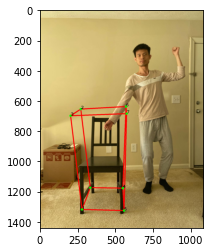

In [18]:
annotated_img = draw_box_intersection(img, left_hand, vertices_world, bounding_boxes_chair_2d)

plt.imshow(annotated_img)
plt.show()
# Check succeed!
# (1440, 1080, 3)

## Part 6: Do it with your own image!

This project is specified designed to make you interact with your own image and accumulate more real-world computer vision project experience. And so, you're required to take your own pictures, doing the calibration task on your own, running detection and estimation with your code. The result you get will be written in the report. To make things easier, we summarize several important tips for you:
- Take pictures for both before (hand is far from chair) and after interaction, and show it in the report
- Use the same camera and focal length for both calibration pictures and interaction pictures
- Use the pictures of the same resolution for all the tasks; Usually, phone camera use different zoom for taking pictures and record videos. As such, in the extra credit part, you can consider making a video which combines both camera calibration and human pose interaction. After it, extracting frames of the calibration part and use these pictures for calibration.
- `Mediapipe` and `Objectron` do not work for all the situations. So, if you find some pictures do not work in the detection part, firstly, try to change the subject and pose, secondly, try to change the environment, lights, background, etc. You should still be able to find many working situations
- The detection may not be able to work very precisely, and so you're allowed to slightly change a few real-world parameters, such as the size of chair, the depth of pose (the real-world distance between the people in the picture and the camera)


## Extra Credit: Intersection Detection in a Video

Now that you have a working pipeline for a single image, we would like to improve the output by processing a video and looking into more than one object. Thus, there are two extra credit items:
- (3 pts) Video processing: Write a code that is able to read a video file and apply the pipeline to it. The video should show yourself interacting with the chairs by letting part of your hand intersect with the chair's 'bounding box', then removing it. The bounding box should change colors while your hand is inside it. An example video is provided for you in the `data` folder. How you decide to apply the steps to the video is up to you, but we suggest trying to split the video into a sequence of images first, then running the above pipeline on them. To do that, fill in the code in extra_credit_video.py, and run the following cell. You can look at cv2's VideoCapture and VideoWriter to help with this here. You should save the resulting video and include it in your submission, (uploading it to youtube and providing a link would also be accepted). Regardless of how you submit it, let us know where to access it in the report section.
- (4 pts) Interacting with multiple object: Record a video with two chairs and yourself interacting with each one at a time. The bounding box should change colors while your hand is inside the each chair. If you record the two chairs interaction video, then you don't have to do the one chair video again because requirements are already satisfied.

Hints for detecting two chairs: You will have to change your code to be able to detect the hand for each chair. Read the [objectron repository](https://github.com/yas-sim/objectron-3d-object-detection-openvino) and try to understand what the algorithm does, because it is already implemented to detect multiple objects. The repo code is tested to run on Ubuntu 18 and most likely, only on that single operating system. You should not rely on that repository to do this task.

In the report, you have to answer all the questions to receive full credit for extra credit part.

In [19]:
from proj5_code.extra_credit_video import process_video

video_path = '../data/raw.mp4' #CHANGE THIS TO YOUR OWN VIDEO FILE
process_video(video_path)

['image1.jpg', 'image2.jpg', 'image3.jpg', 'image4.jpg', 'image5.jpg', 'image6.jpg']


## Code testing
We have provided a set of tests for you to evaluate your implementation. We have included tests inside ```proj5.ipynb``` so you can check your progress as you implement each section. At the end, you should call the tests from the terminal using the command ```pytest proj5_unit_tests/```

## Submission

This is very important as you will lose 5 points for every time you do not follow the instructions.

Do not install any additional packages inside the conda environment. The TAs will use the same environment as defined in the config files we provide you, so anything that's not in there by default will probably cause your code to break during grading. Do not use absolute paths in your code or your code will break. Use relative paths like the starter code already does. Failure to follow any of these instructions will lead to point deductions. Create the zip file using ```python zip_submission.py --gt_username <your_gt_username>``` (it will zip up the appropriate directories/files for you!) and hand it through Gradescope. Remember to submit your report as a PDF to Gradescope as well.

## Rubric
The overall rubric division for this part is:

| Submission Type | Credit Type | Individual |
| --------------- | ----------- | ---------- |
| Code            | Mandatory   | 30         |
| Report          | Mandatory   | 70         |
| Report          | EC          | 7          |
| Total           |             | 107        | 



## Credit

Assignment developed by Sen Wang, Jing Wu, Vijay Upadhya, Haoxin Ma, Sergio Aguilera and Frank Dellaert.